In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


import hydra
from typing import Optional
from collections.abc import Callable
from omegaconf import OmegaConf, DictConfig
from data_module.lightning_data_module import DataModule
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

In [2]:
def setup(cfg):

    cfg.loader.batch_size = 1

    if 'split' not in cfg:
        cfg.split = 'val'

    if 'shuffle' not in cfg:
        cfg.shuffle = False
        
def setup_config(cfg: DictConfig, override: Optional[Callable] = None):

    OmegaConf.set_struct(cfg, False)
    OmegaConf.resolve(cfg)
    OmegaConf.set_struct(cfg, True)


def merge_rgbs(imgs):

    fl = np.transpose(imgs[0], (1,2,0))
    ff = np.transpose(imgs[1], (1,2,0))
    fr = np.transpose(imgs[2], (1,2,0))

    front = np.hstack([fl, ff, fr])

    bl = np.transpose(imgs[5], (1,2,0))
    bf = np.transpose(imgs[4], (1,2,0))
    br = np.transpose(imgs[3], (1,2,0))

    back = np.hstack([bl, bf, br])

    whole = np.vstack([front, back])

    return whole

def vis_gt(bev):
    bev = np.transpose(bev, (1, 2, 0))
    area = bev[:,:,0] + bev[:,:,1]
    divider = bev[:,:,2] + bev[:,:,3]
    vehicle = bev[:,:,4] + bev[:,:,5] + bev[:,:,6] + bev[:,:,7]

    h, w = area.shape
    vis = np.full((h, w, 3), 255, dtype='uint8')

    
    for i, bibev in enumerate([area, divider, vehicle]):
    # for i, bibev in enumerate([area, vehicle]):
        vis[bibev!=0,:] = mapping[i]
    
    vis[95:105, 98:102, :] = (255, 0, 0)

    return vis

In [3]:
# *  config setup  * #
CONFIG_PATH = '/usr/src/CV_For_Autonomous_Driving/config'

with initialize_config_dir(config_dir=CONFIG_PATH):
    cfg = compose(config_name='default_config_debug.yaml')
    
setup_config(cfg, setup)

# dataset list 만드는 test
DM = DataModule('nuscenes_generated', cfg.data, cfg.loader)
val_dataloader = DM.val_dataloader()
split = 'train'
data_cfg_our = DM.data_cfg
datasets = DM.get_data(split=split,
                            **data_cfg_our)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  after removing the cwd from sys.path.


In [4]:
data = datasets[0].__getitem__(10)  

self.dataset_dir, lidar_path /usr/src/nuscenes samples/LIDAR_TOP/n015-2018-07-18-11-07-57+0800__LIDAR_TOP__1531883535448683.pcd.bin


In [5]:
aug_img = data['image'][0].numpy().transpose(1,2,0)
img = data['images_before_crop'][0].numpy().transpose(1,2,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


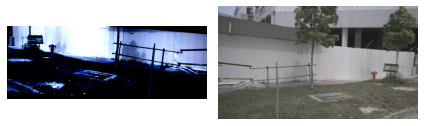

In [6]:
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(aug_img)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img)

plt.tight_layout()
plt.show()

In [7]:
from PIL import Image
import numpy as np
import torch

In [8]:

np.random.seed(42)
num_classes = 12


#! BEVDepth aug vars
is_train = True
ida_aug_conf ={ 'resize_lim': [0.386, 0.55],
                'final_dim':  [256, 704],
                'rot_lim': [-5.4, 5.4],
                'H': 900,
                'W': 1600,
                'rand_flip': True,
                'bot_pct_lim' : [0.0, 0.0],
                'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT',
                    'CAM_BACK', 'CAM_BACK_RIGHT' ],
                'Ncams': 6 }
bda_aug_conf= { 'rot_lim': [-22.5, 22.5],
                'scale_lim': [0.95, 1.05],
                'flip_dx_ratio': 0.5,
                'flip_dy_ratio': 0.5 }
img_conf = dict(img_mean=[123.675, 116.28, 103.53],
                img_std=[58.395, 57.12, 57.375],
                to_rgb=True)
img_mean = np.array(img_conf['img_mean'], np.float32)
img_std = np.array(img_conf['img_std'], np.float32)
to_rgb = img_conf['to_rgb']

def get_sensor2sensor_mat():
    sensor2sensor_mat = np.full((4, 4), 1e-9, dtype=np.float32)
    np.fill_diagonal(sensor2sensor_mat, 1.0)
    return sensor2sensor_mat


def img_transform(img, resize, resize_dims, crop, flip, rotate):
    ida_rot = torch.eye(2)
    ida_tran = torch.zeros(2)

    # adjust image
    img = img.resize(resize_dims)
    img = img.crop(crop)
    if flip:
        img = img.transpose(method=Image.FLIP_LEFT_RIGHT)
    img = img.rotate(rotate)

    print('crop:', crop)
    # post-homography transformation
    ida_rot *= resize
    ida_tran -= torch.Tensor(crop[:2])
    print('ida_tran1 :', ida_tran)
    if flip:
        A = torch.Tensor([[-1, 0], [0, 1]])
        b = torch.Tensor([crop[2] - crop[0], 0])
        print('A:', A)
        print('b:', b)
        
        ida_rot = A.matmul(ida_rot)
        ida_tran = A.matmul(ida_tran) + b
        print('ida_tran2 :', ida_tran)
    A = get_rot(rotate / 180 * np.pi)
    b = torch.Tensor([crop[2] - crop[0], crop[3] - crop[1]]) / 2
    print('b :', b)
    print('A.matmul(-b)  :', A.matmul(-b))
    b = A.matmul(-b) + b
    print('A.matmul(-b) + b :', b)
    ida_rot = A.matmul(ida_rot)
    ida_tran = A.matmul(ida_tran) + b
    print('ida_rot :', ida_rot)
    print('ida_tran3 :', ida_tran)
    ida_mat = ida_rot.new_zeros(4, 4)
    ida_mat[3, 3] = 1
    ida_mat[2, 2] = 1
    ida_mat[:2, :2] = ida_rot
    ida_mat[:2, 3] = ida_tran
    print('ida_mat:',ida_mat)
    return img, ida_mat

def get_rot(h):
    return torch.Tensor([
        [np.cos(h), np.sin(h)],
        [-np.sin(h), np.cos(h)],
    ])

def sample_ida_augmentation():
    """Generate ida augmentation values based on ida_config."""
    H, W =  ida_aug_conf['H'], ida_aug_conf['W']
    fH, fW = ida_aug_conf['final_dim']
    if is_train:
        resize = np.random.uniform(*ida_aug_conf['resize_lim'])
        resize_dims = (int(W * resize), int(H * resize))
        newW, newH = resize_dims
        crop_h = int(
            (1 - np.random.uniform(*ida_aug_conf['bot_pct_lim'])) *
            newH) - fH
        print('newW - fW',newW - fW)
        crop_w = int(np.random.uniform(0, max(0, newW - fW)))
        crop = (crop_w, crop_h, crop_w + fW, crop_h + fH)
        flip = False
        if  ida_aug_conf['rand_flip'] and np.random.choice([0, 1]):
            flip = True
        rotate_ida = np.random.uniform(*ida_aug_conf['rot_lim'])
    else:
        resize = max(fH / H, fW / W)
        resize_dims = (int(W * resize), int(H * resize))
        newW, newH = resize_dims
        crop_h = int( (1 - np.mean(ida_aug_conf['bot_pct_lim'])) * newH) - fH
        crop_w = int(max(0, newW - fW) / 2)
        crop = (crop_w, crop_h, crop_w + fW, crop_h + fH)
        flip = False
        rotate_ida = 0
    return resize, resize_dims, crop, flip, rotate_ida

# Image Augmentation

In [9]:
import torchvision.transforms as T
resize, resize_dims, crop, flip, rotate = sample_ida_augmentation()

# img = Image.fromarray(img)
# img = T.ToPILImage(data['images_before_crop'][0])
img_ori= data['images_before_crop'][0].numpy().transpose(1,2,0)
# print(np.unique(img_ori))
img = Image.fromarray((img_ori * 255).astype(np.uint8), 'RGB')



newW - fW 11


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  """


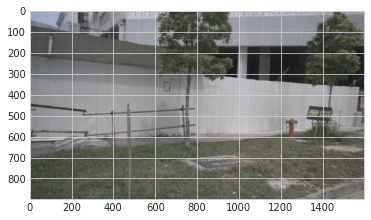

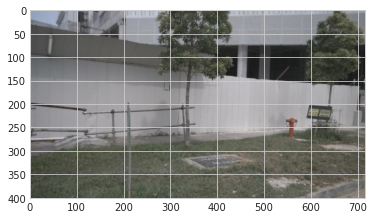

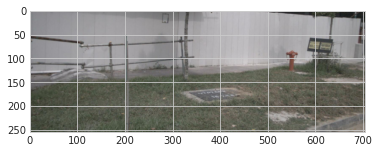

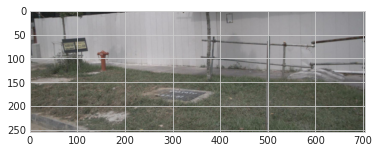

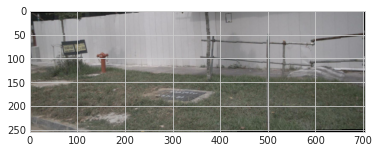

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


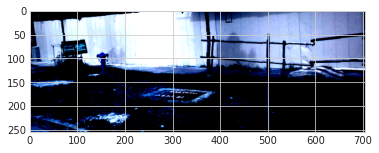

In [10]:
import mmcv
img_resize = img.resize(resize_dims)
img_crop = img_resize.crop(crop)
# if flip:
img_flip = img_crop.transpose(method=Image.FLIP_LEFT_RIGHT)
img_rotate = img_flip.rotate(rotate)
image_new = mmcv.imnormalize(np.array(img_rotate), img_mean,
                                       img_std, to_rgb)

plt.imshow(img)
plt.show()
plt.imshow(img_resize)
plt.show()
plt.imshow(img_crop)
plt.show()
plt.imshow(img_flip)
plt.show()
plt.imshow(img_rotate)
plt.show()
plt.imshow(image_new)
plt.show()

In [11]:
rotate

1.0459817058220597

In [12]:
ida_rot = torch.eye(2)
ida_tran = torch.zeros(2)

# adjust image
img = img.resize(resize_dims)
img = img.crop(crop)
if flip:
    img = img.transpose(method=Image.FLIP_LEFT_RIGHT)
img = img.rotate(rotate)

# post-homography transformation
ida_rot *= resize
ida_tran -= torch.Tensor(crop[:2])
# print('ida_tran1 :', ida_tran)
if flip:
    A = torch.Tensor([[-1, 0], [0, 1]])
    b = torch.Tensor([crop[2] - crop[0], 0])
    # print('A:', A)
    # print('b:', b)
    
    ida_rot = A.matmul(ida_rot)
    ida_tran = A.matmul(ida_tran) + b
    # print('ida_tran2 :', ida_tran)
A = get_rot(rotate / 180 * np.pi)
b = torch.Tensor([crop[2] - crop[0], crop[3] - crop[1]]) / 2
# print('b :', b)
# print('A.matmul(-b)  :', A.matmul(-b))
b = A.matmul(-b) + b
# print('A.matmul(-b) + b :', b)
ida_rot = A.matmul(ida_rot)
ida_tran = A.matmul(ida_tran) + b
# print('ida_rot :', ida_rot)
# print('ida_tran3 :', ida_tran)
ida_mat = ida_rot.new_zeros(4, 4)
ida_mat[3, 3] = 1
ida_mat[2, 2] = 1
ida_mat[:2, :2] = ida_rot
ida_mat[:2, 3] = ida_tran 

In [13]:
# 3d bbox 
mapping = {0: (255, 153, 51),
            1: (0, 128, 255),
            2: (0, 0, 255)}

bev_map = np.full((200, 200, 3), 255)

gt_bbox = data['gt_boxes']
gt_cls = data['gt_labels'].numpy()

# merge images

merged_imgs = merge_rgbs(data['image'].numpy())
# bev: torch.Size([200, 200, 12])
bev = vis_gt(data['bev'].numpy())

# np.unique(data['bev'][0].numpy())

cls_mapping = {}
for i in range(10):
    cls_mapping[i] = np.random.rand((3))*255


from data_module.dataset.utils import *
#(0,0), top left
bev_cfg = {'h': 200, 'w': 200, 
                    'h_meters': 100.0, 'w_meters': 100.0, 'offset': 0.0}
meter2pix = get_bev_meter2pix_matrix(bev_cfg)



def rotate_points_along_z(points, angle):
    """
    Args:
        points: (B, N, 3 + C)
        angle: (B), angle along z-axis, angle increases x ==> y
    Returns:
    """
    cosa = np.cos(angle)
    sina = np.sin(angle)
    zeros = np.zeros(points.shape[0])
    ones = np.ones(points.shape[0])
    rot_matrix = np.stack(
        (cosa, sina, zeros, -sina, cosa, zeros, zeros, zeros, ones),
        axis=1).reshape(-1, 3, 3)
    points_rot = np.matmul(points[:, :, 0:3], rot_matrix)
    points_rot = np.concatenate((points_rot, points[:, :, 3:]), axis=-1)
    return points_rot


def get_bev_lines(corners):
    return [[[corners[i, 0], corners[(i + 1) % 4, 0]],
             [corners[i, 1], corners[(i + 1) % 4, 1]]] for i in range(4)]

def get_corners(boxes3d):
    """
        7 -------- 4
       /|         /|
      6 -------- 5 .
      | |        | |
      . 3 -------- 0
      |/         |/
      2 -------- 1
    Args:
        boxes3d:  (N, 7) [x, y, z, dx, dy, dz, heading],
            (x, y, z) is the box center
    Returns:
    """
    template = (np.array((
        [1, 1, -1],
        [1, -1, -1],
        [-1, -1, -1],
        [-1, 1, -1],
        [1, 1, 1],
        [1, -1, 1],
        [-1, -1, 1],
        [-1, 1, 1],
    )) / 2)

    corners3d = np.tile(boxes3d[:, None, 3:6],
                        [1, 8, 1]) * template[None, :, :]
    corners3d = rotate_points_along_z(corners3d.reshape(-1, 8, 3),
                                      boxes3d[:, 6]).reshape(-1, 8, 3)
    corners3d += boxes3d[:, None, 0:3]

    return corners3d


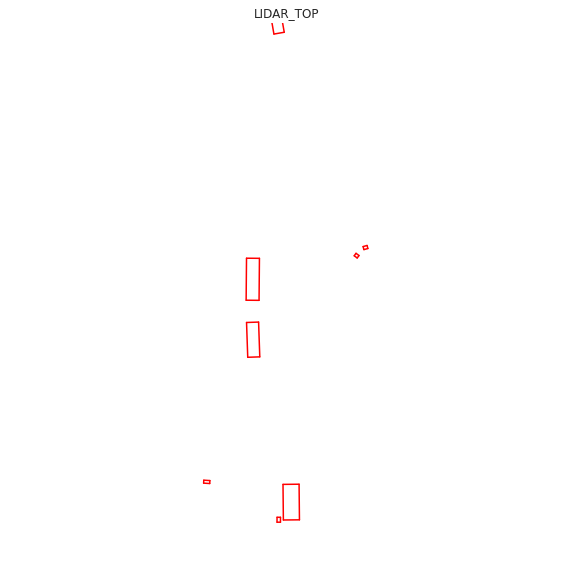

In [14]:
import matplotlib.patches as patches

bev_map = np.full((200, 200), 255)


gt_corners = []
for i in range(len(gt_bbox)):
    box = gt_bbox[i].numpy()
    if np.linalg.norm(box[:2]) <= 60:
        corners = get_corners(box[None])[0]
        gt_corners.append(corners)


plt.figure(figsize=(10, 10))

# Set BEV attributes
plt.title('LIDAR_TOP')
plt.axis('equal')
plt.axis('off')
plt.xlim(-50, 50)
plt.ylim(-50, 50)

for corners in gt_corners:
    lines = get_bev_lines(corners)
    for line in lines:
        plt.plot([-x for x in line[1]],
                    line[0],
                    c='r',
                    label='ground truth')



# Depth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.86406159  2.87179971  2.90677166 ... 24.87650299 53.31340027
 53.63890457]


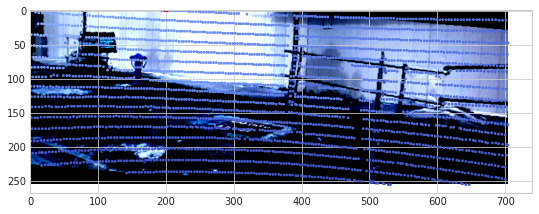

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))

# fig.canvas.set_window_title(sample_token)
img = np.transpose(data['image'][0].numpy(), (1,2,0))
depth = data['depths'][0].numpy()

h, w = depth.shape

x = np.linspace(0, w, w)
y = np.linspace(0, h, h)
xs, ys = np.meshgrid(x, y)

xs_flat = xs.flatten()
ys_flat = ys.flatten()
depth_flat = depth.flatten()

mask = depth_flat > 1e-5
xs_filter = xs_flat[mask]
ys_filter = ys_flat[mask]
depth_filter = depth_flat[mask]

print(np.unique(depth_filter))

ax.imshow(img)
ax.scatter(xs_filter, ys_filter, c=depth_filter, s=3, cmap='coolwarm') 


# ax.axis('off')
